# **Toxic Comment Classification**

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, GRU, Bidirectional

## Importing the dataset

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [2]:
import shutil
import os
shutil.copy('/content/drive/MyDrive/data.csv', os.getcwd())

'/content/data.csv'

In [3]:
dataSet = pd.read_csv('data.csv')

In [4]:
X = dataSet['X'].values

In [5]:
y = dataSet['y'].values

## Splitting the dataset into the Training set and Test set

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Tokenization

In [7]:
num_words = 20000

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

vocab_size

107152

## Embedding

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

maxlen = 200

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [10]:
X_train.shape

(111659, 200)

## BiLSTM

### Setting the seed

In [11]:
'''
seed_value = 8149339

import random
random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

np.random.seed(seed_value)

import os
os.environ['PYTHONHASHSEED']=str(seed_value)
'''

"\nseed_value = 8149339\n\nimport random\nrandom.seed(seed_value)\n\nimport tensorflow as tf\ntf.random.set_seed(seed_value)\n\nnp.random.seed(seed_value)\n\nimport os\nos.environ['PYTHONHASHSEED']=str(seed_value)\n"

### Building the model

In [12]:
embedding_dim = 100

# Initialising the model
model = Sequential()

# Adding Embedding layer
model.add(Embedding(input_dim = vocab_size, 
                    output_dim = embedding_dim, 
                    input_length = maxlen))

# Adding BiLSTM layers
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())

# Adding full connection layer
model.add(Dense(64, activation="relu"))

# Adding the output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          10715200  
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          98816     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 10,906,817
Trainable params: 10,906,817
Non-trainable params: 0
____________________________________________

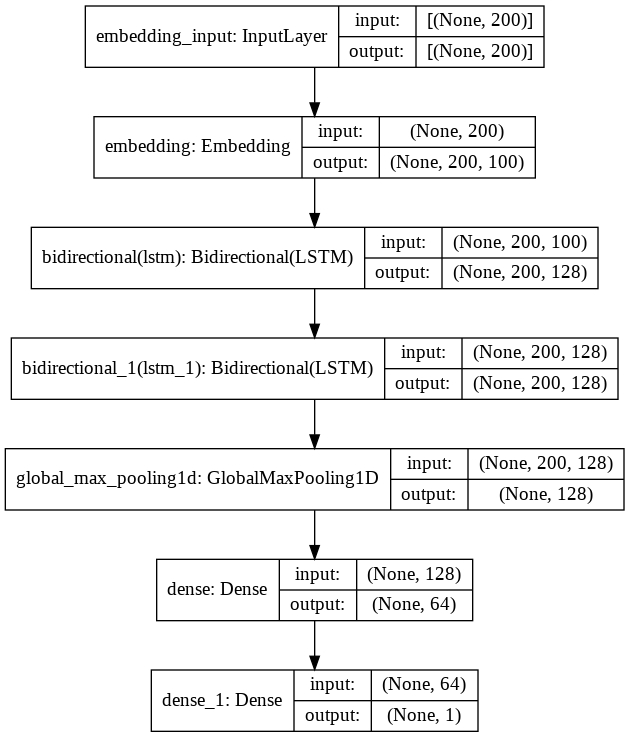

In [20]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='BiLSTM.png', show_shapes=True)

In [15]:
# Fitting the model to the Training set
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128)

Epoch 1/2
873/873 [==============================] - 143s 157ms/step - loss: 0.2195 - accuracy: 0.9312 - val_loss: 0.1029 - val_accuracy: 0.9625
Epoch 2/2
873/873 [==============================] - 135s 154ms/step - loss: 0.0838 - accuracy: 0.9691 - val_loss: 0.1041 - val_accuracy: 0.9627


### Making the predictions and visualising the results

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

def report(y_test, y_pred):

  cm = confusion_matrix(y_test, y_pred)

  acc = np.round(accuracy_score(y_test, y_pred)*100, 2)
  p = np.round(precision_score(y_test, y_pred)*100, 2)
  r = np.round(recall_score(y_test, y_pred)*100, 2)
  f1 = np.round(f1_score(y_test, y_pred)*100, 2)

  data = [acc, p, r, f1]

  idx = ['Accuracy', 'Precision', 'Recall', 'F1']
  results = pd.DataFrame(index=idx, data = data, columns=['Value'])
  results.index.name = 'Metric'
  display(results)

  plt.figure(figsize=(7, 5))
  sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt = 'd', annot_kws={"size": 30}).set_title('Confusion Matrix')
  plt.show()

,Value
Metric,
Accuracy,96.27
Precision,85.99
Recall,75.54
F1,80.43


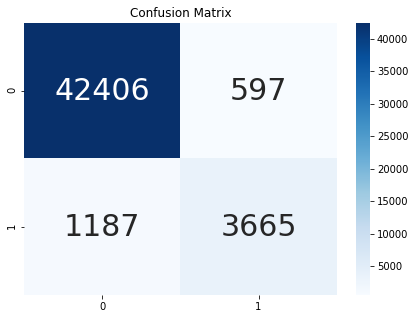

In [19]:
y_pred = model.predict(X_test) > 0.5

report(y_test, y_pred)

### Saving the model

In [21]:
model.save('BiLSTM.h5')